In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [72]:
input_size = 1 # no of past data to to consider
num_steps = 1 # consecutive input elements are grouped into one training input
lstm_size = 128 #number of units in one LSTM layer
num_layers=1  # no of layers
keep_prob=0.8 # keep probability of each node
batch_size = 64 # batch size of input data
learning_rate = 0.001 # learning rate
max_epoch = 200 # no of epochs
test_train_split = 0.8 #test train split

In [73]:
prices_dataset_train =  pd.read_csv('Google_Stock_Price_Train.csv', header=0)
prices_dataset_test =  pd.read_csv('Google_Stock_Price_Test.csv', header=0)

In [74]:
prices_dataset_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [75]:
prices_dataset_test.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [76]:
#google_stock_prices_train = prices_dataset_train["Close"]
#google_stock_prices_test = prices_dataset_test["Close"]
google_stock_prices_train = prices_dataset_train.Close.values.astype('float32')
google_stock_prices_test = prices_dataset_test.Close.values.astype('float32')

In [77]:
print("train shape: ",google_stock_prices_train.shape)
print("test shape: ",google_stock_prices_test.shape)

train shape:  (1258,)
test shape:  (20,)


In [78]:
## preprocessing of data, scale data into a scale of 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
google_stock_prices_train = scaler.fit_transform(google_stock_prices_train)
google_stock_prices_test = scaler.fit_transform(google_stock_prices_test)

/home/pankaj/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/pankaj/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/pankaj/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data h

In [79]:
def create_dataset(seq, input_size, num_steps):
    # group according to input size
    seq = [np.array(seq[i * input_size: (i + 1) * input_size]) for i in range(len(seq) // input_size)]
    
    # Split into groups of `num_steps`
    X = np.array([seq[i: i + num_steps] for i in range(len(seq) - num_steps)])
    y = np.array([seq[i + num_steps] for i in range(len(seq) - num_steps)])
    return X,y

In [80]:
train = google_stock_prices_train
test = google_stock_prices_test

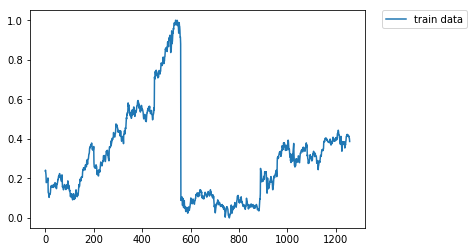

In [81]:
# train data
plt.plot(train, label = 'train data')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

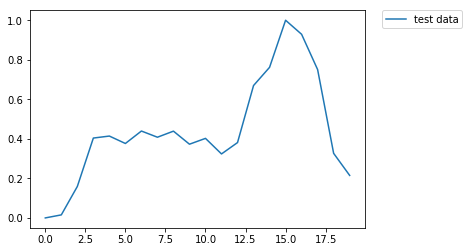

In [82]:
#test data
plt.plot(test, label ='test data')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [83]:
## create data test and train
train_x,train_y = create_dataset(train,input_size, num_steps)
test_x,test_y = create_dataset(test,input_size, num_steps)

## ANN

In [84]:
tf.reset_default_graph()
ann_graph = tf.Graph()

In [85]:
with ann_graph.as_default():
    inputs = tf.placeholder(tf.float32, [None, num_steps, input_size])
    targets = tf.placeholder(tf.float32, [None, input_size])
    # reshape the inputs
    inputs_reshape = tf.reshape(inputs, [-1, num_steps * input_size])
        
    # declare weights and biases
    W_1 = tf.get_variable(
            name='W_1',
            shape=[num_steps * input_size, lstm_size],
            initializer = tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
    
    B_1 = tf.get_variable(
            name='B_1',
            shape=[lstm_size],
            initializer = tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
    
    H_1 = tf.nn.bias_add(
            name='H_1',
            value=tf.matmul(inputs_reshape, W_1),
            bias=B_1)
    
    H_1 = tf.nn.relu(H_1)
    
    W_2 = tf.get_variable(
            name='W_2',
            shape=[lstm_size, 1],
            initializer = tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
    
    B_2 = tf.get_variable(
            name='B_2',
            shape=[1],
            initializer = tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
    
    logits = tf.nn.bias_add(
            name='logits',
            value=tf.matmul(H_1, W_2),
            bias=B_2)
    
    ## define cost function and minimize it
    loss = tf.reduce_mean(tf.square(logits - targets))
    optimizer = tf.train.AdamOptimizer(learning_rate)
    minimize = optimizer.minimize(loss)

In [86]:
with tf.Session(graph=ann_graph) as sess:
    tf.global_variables_initializer().run()
    
    for epoch_step in range(max_epoch):
        avg_cost = 0.
        total_batch = int(len(train_x)/batch_size)
        
        for i in range(total_batch):
            batch_X = train_x[(i*batch_size):((i*batch_size)+batch_size)]
            batch_y = train_y[(i*batch_size):((i*batch_size)+batch_size)]
            train_loss, _ = sess.run([loss, minimize], feed_dict = {inputs: batch_X, targets: batch_y})
            avg_cost += train_loss / total_batch
            
        if (epoch_step) % 1 == 0:
            print("Epoch:", '%04d' % (epoch_step+1), "cost= ",(avg_cost))
    
    prd_value = sess.run(logits, feed_dict = {inputs: test_x})  

Epoch: 0001 cost=  0.0783474714936
Epoch: 0002 cost=  0.0367860439736
Epoch: 0003 cost=  0.0272966089634
Epoch: 0004 cost=  0.0210497931893
Epoch: 0005 cost=  0.016091402133
Epoch: 0006 cost=  0.0119070412551
Epoch: 0007 cost=  0.00843004833548
Epoch: 0008 cost=  0.00574470077194
Epoch: 0009 cost=  0.00378285456559
Epoch: 0010 cost=  0.00245700258069
Epoch: 0011 cost=  0.00163499822405
Epoch: 0012 cost=  0.00117002782568
Epoch: 0013 cost=  0.000931137939532
Epoch: 0014 cost=  0.000819653895298
Epoch: 0015 cost=  0.00077227601325
Epoch: 0016 cost=  0.000753371077161
Epoch: 0017 cost=  0.000745929609509
Epoch: 0018 cost=  0.000742641904492
Epoch: 0019 cost=  0.000740329666051
Epoch: 0020 cost=  0.000738642004236
Epoch: 0021 cost=  0.000737312327194
Epoch: 0022 cost=  0.000736081421277
Epoch: 0023 cost=  0.000735034744905
Epoch: 0024 cost=  0.000734134116532
Epoch: 0025 cost=  0.000733370101156
Epoch: 0026 cost=  0.000732679196134
Epoch: 0027 cost=  0.000731793061852
Epoch: 0028 cost=  0.

In [87]:
# unscale the data first
test_unscaled = scaler.inverse_transform(test)
prd_value_unscaled = scaler.inverse_transform(prd_value)

/home/pankaj/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


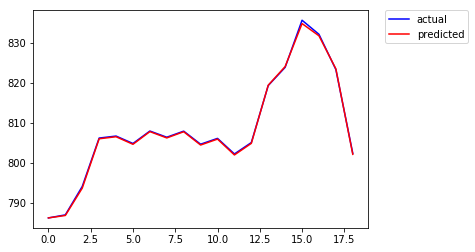

In [88]:
# plot the data points
plt.plot(test_unscaled[:-1],'b', label = 'actual')
plt.plot(prd_value_unscaled[:],'r', label = 'predicted')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### RNN

In [89]:
tf.reset_default_graph()
rnn_graph = tf.Graph()

In [90]:
with rnn_graph.as_default():
    inputs = tf.placeholder(tf.float32, [None, num_steps, input_size])
    targets = tf.placeholder(tf.float32, [None, input_size])
    #learning_rate = tf.placeholder(tf.float32, None)
    
    def create_one_cell():
        return tf.contrib.rnn.BasicRNNCell(lstm_size)
        if keep_prob < 1.0:
            return tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob=keep_prob)
        
    ##stack the cells into multiple layers if needed. MultiRNNCell helps connect sequentially multiple 
    ##simple cells to compose one cell.    
    if num_layers > 1:
        cell = tf.contrib.rnn.MultiRNNCell([create_one_cell() for _ in range(num_layers)], state_is_tuple=True)
    else:
        cell = create_one_cell()
        
    ## tf.nn.dynamic_rnn constructs a recurrent neural network specified by cell (RNNCell). 
    ## It returns a pair of (model outpus, state), where the outputs val is of size (batch_size, num_steps, 
    ## lstm_size) by default. The state refers to the current state of the LSTM cell, not consumed here.    
    val, _ = tf.nn.dynamic_rnn(cell, inputs, dtype=tf.float32)
    
    # Before transpose, val.get_shape() = (batch_size, num_steps, lstm_size)
    # After transpose, val.get_shape() = (num_steps, batch_size, lstm_size)
    val = tf.transpose(val, [1, 0, 2])
    # last.get_shape() = (batch_size, lstm_size)
    last = tf.gather(val, int(val.get_shape()[0]) - 1, name="last_rnn_output")
    
    # Define weights and biases between the hidden and output layers.
    weight = tf.Variable(tf.truncated_normal([lstm_size, input_size]))
    bias = tf.Variable(tf.constant(0.1, shape=[input_size]))
    prediction = tf.matmul(last, weight) + bias
    
    ## define cost function and minimize it
    loss = tf.reduce_mean(tf.square(prediction - targets))
    optimizer = tf.train.AdamOptimizer(learning_rate)
    minimize = optimizer.minimize(loss)

/home/pankaj/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [91]:
with tf.Session(graph=rnn_graph) as sess:
    tf.global_variables_initializer().run()
    
    for epoch_step in range(max_epoch):
        avg_cost = 0.
        total_batch = int(len(train_x)/batch_size)
        
        for i in range(total_batch):
            batch_X = train_x[(i*batch_size):((i*batch_size)+batch_size)]
            batch_y = train_y[(i*batch_size):((i*batch_size)+batch_size)]
            train_loss, _ = sess.run([loss, minimize], feed_dict = {inputs: batch_X, targets: batch_y})
            avg_cost += train_loss / total_batch
            
        if (epoch_step) % 1 == 0:
            print("Epoch:", '%04d' % (epoch_step+1), "cost= ",(avg_cost))
    
    prd_value = sess.run(prediction, feed_dict = {inputs: test_x})    

Epoch: 0001 cost=  0.00929870327175
Epoch: 0002 cost=  0.00950374814841
Epoch: 0003 cost=  0.00886038247968
Epoch: 0004 cost=  0.00798261903631
Epoch: 0005 cost=  0.00682943917529
Epoch: 0006 cost=  0.00573378815898
Epoch: 0007 cost=  0.00585576317328
Epoch: 0008 cost=  0.00592810393152
Epoch: 0009 cost=  0.00723369018861
Epoch: 0010 cost=  0.00801416156709
Epoch: 0011 cost=  0.00957649605851
Epoch: 0012 cost=  0.00960615914205
Epoch: 0013 cost=  0.00965358997468
Epoch: 0014 cost=  0.00807967752917
Epoch: 0015 cost=  0.00712160746824
Epoch: 0016 cost=  0.00561371835954
Epoch: 0017 cost=  0.00515679675951
Epoch: 0018 cost=  0.00442639504955
Epoch: 0019 cost=  0.00461249049036
Epoch: 0020 cost=  0.00447254619825
Epoch: 0021 cost=  0.00522476712573
Epoch: 0022 cost=  0.0055927138892
Epoch: 0023 cost=  0.0069551465414
Epoch: 0024 cost=  0.00774293639513
Epoch: 0025 cost=  0.00944026293061
Epoch: 0026 cost=  0.00994547927066
Epoch: 0027 cost=  0.0108239250472
Epoch: 0028 cost=  0.0099093589

In [92]:
# unscale the data first
test_unscaled = scaler.inverse_transform(test)
prd_value_unscaled = scaler.inverse_transform(prd_value)

/home/pankaj/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


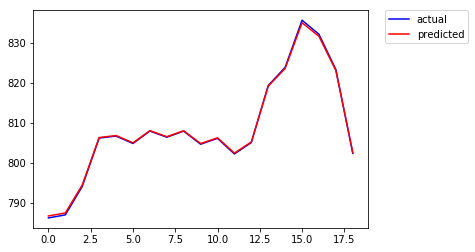

In [93]:
# plot the data points
plt.plot(test_unscaled[:-1],'b', label = 'actual')
plt.plot(prd_value_unscaled[:],'r', label = 'predicted')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### LSTM

In [94]:
tf.reset_default_graph()
lstm_graph = tf.Graph()

In [95]:
with lstm_graph.as_default():
    inputs = tf.placeholder(tf.float32, [None, num_steps, input_size])
    targets = tf.placeholder(tf.float32, [None, input_size])
    #learning_rate = tf.placeholder(tf.float32, None)
    
    def create_one_cell():
        return tf.contrib.rnn.LSTMCell(lstm_size, state_is_tuple=True)
        if keep_prob < 1.0:
            return tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob=keep_prob)
        
    ##stack the cells into multiple layers if needed. MultiRNNCell helps connect sequentially multiple 
    ##simple cells to compose one cell.    
    if num_layers > 1:
        cell = tf.contrib.rnn.MultiRNNCell([create_one_cell() for _ in range(num_layers)], state_is_tuple=True)
    else:
        cell = create_one_cell()
        
    ## tf.nn.dynamic_rnn constructs a recurrent neural network specified by cell (RNNCell). 
    ## It returns a pair of (model outpus, state), where the outputs val is of size (batch_size, num_steps, 
    ## lstm_size) by default. The state refers to the current state of the LSTM cell, not consumed here.    
    val, _ = tf.nn.dynamic_rnn(cell, inputs, dtype=tf.float32)
    
    # Before transpose, val.get_shape() = (batch_size, num_steps, lstm_size)
    # After transpose, val.get_shape() = (num_steps, batch_size, lstm_size)
    val = tf.transpose(val, [1, 0, 2])
    # last.get_shape() = (batch_size, lstm_size)
    last = tf.gather(val, int(val.get_shape()[0]) - 1, name="last_lstm_output")
    
    # Define weights and biases between the hidden and output layers.
    weight = tf.Variable(tf.truncated_normal([lstm_size, input_size]))
    bias = tf.Variable(tf.constant(0.1, shape=[input_size]))
    prediction = tf.matmul(last, weight) + bias
    
    ## define cost function and minimize it
    loss = tf.reduce_mean(tf.square(prediction - targets))
    optimizer = tf.train.AdamOptimizer(learning_rate)
    minimize = optimizer.minimize(loss)
    

/home/pankaj/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [96]:
with tf.Session(graph=lstm_graph) as sess:
    tf.global_variables_initializer().run()
    
    for epoch_step in range(max_epoch):
        avg_cost = 0.
        total_batch = int(len(train_x)/batch_size)
        
        for i in range(total_batch):
            batch_X = train_x[(i*batch_size):((i*batch_size)+batch_size)]
            batch_y = train_y[(i*batch_size):((i*batch_size)+batch_size)]
            train_loss, _ = sess.run([loss, minimize], feed_dict = {inputs: batch_X, targets: batch_y})
            avg_cost += train_loss / total_batch
            
        if (epoch_step) % 1 == 0:
            print("Epoch:", '%04d' % (epoch_step+1), "cost= ",(avg_cost))
    
    prd_value = sess.run(prediction, feed_dict = {inputs: test_x})    

Epoch: 0001 cost=  0.0328973530375
Epoch: 0002 cost=  0.0152986478382
Epoch: 0003 cost=  0.00841490991374
Epoch: 0004 cost=  0.00363253843113
Epoch: 0005 cost=  0.00181371323982
Epoch: 0006 cost=  0.0009888079516
Epoch: 0007 cost=  0.000782676569591
Epoch: 0008 cost=  0.000740867092023
Epoch: 0009 cost=  0.000739048946248
Epoch: 0010 cost=  0.000740042327379
Epoch: 0011 cost=  0.00074111126014
Epoch: 0012 cost=  0.000741890020819
Epoch: 0013 cost=  0.00074263075964
Epoch: 0014 cost=  0.000743401341759
Epoch: 0015 cost=  0.000744187340483
Epoch: 0016 cost=  0.000744983084779
Epoch: 0017 cost=  0.000745780396468
Epoch: 0018 cost=  0.000746577474944
Epoch: 0019 cost=  0.000747377464186
Epoch: 0020 cost=  0.000748182551194
Epoch: 0021 cost=  0.000748993743879
Epoch: 0022 cost=  0.000749810300859
Epoch: 0023 cost=  0.000750631735029
Epoch: 0024 cost=  0.000751458307174
Epoch: 0025 cost=  0.000752289452449
Epoch: 0026 cost=  0.000753125066311
Epoch: 0027 cost=  0.000753963863214
Epoch: 0028 

In [97]:
# unscale the data first
test_unscaled = scaler.inverse_transform(test)
prd_value_unscaled = scaler.inverse_transform(prd_value)

/home/pankaj/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


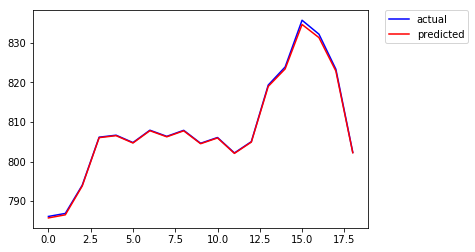

In [98]:
# plot the data points
plt.plot(test_unscaled[:-1],'b', label = 'actual')
plt.plot(prd_value_unscaled[:],'r', label = 'predicted')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)